In [1]:
from knowknow import *

In [2]:
db = Dataset('sociology-jstor-all')

loading variable sociology-jstor-all/_attributes from disk
loading variable sociology-jstor-all/groups from disk


In [50]:
db(t=None).cits.sort_values('count')[-10:]

,t,count
607,work,8097
1479,women,8441
251,two,8449
60,data,9159
166,research,10462
321,may,10715
526,new,11932
517,also,12107
238,one,13339
916,social,23812


In [52]:
db(t1=None, t2='women').cits.sort_values('count')[-10:]

,t1,count
46,social,465
61,family,466
453,less,488
55,likely,513
71,labor,544
248,among,643
335,work,770
5,men-women,950
4,men,2408
2,women,8441


# look at some egonets

In [53]:
", ".join( db(t=None).cits.sort_values('count')[-100:].t )

'second, case, much, marriage, general, structure, could, found, population, school, power, support, review, significant, labor, men, e, community, change, relationship, class, et-al, pp, behavior, example, three, likely, years, well, effect, al, level, high, children, even, public, us, differences, used, age, states, results, society, sociological, et, education, thus, important, many, within, group, different, state, status, studies, new-york, york, people, groups, c, r, less, b, health, sociology, effects, life, see, number, variables, j, theory, economic, use, press, table, first, among, model, journal, however, university, political, p, would, family, study, analysis, time, american, work, women, two, data, research, may, new, also, one, social'

In [54]:
ego = 'marital-status'

In [55]:
neighbors = list( db(t1=ego, t2=None).cits.sort_values('count')[-100:].t2 )

In [56]:
neighbors = neighbors + [ego]

In [57]:
net = defaultdict(int)
for n1 in neighbors:
    for n2 in neighbors:
        if n1 > n2:
            continue
        
        net[(n1,n2)] = db(t1=n1, t2=n2).docs

In [58]:
len(net)

5050

In [59]:
G = nx.Graph()

In [60]:
pct = np.quantile( [w for (n1,n2),w in net.items()], 0.9 )

G.add_weighted_edges_from([
    (n1,n2,w)
    for (n1,n2),w in net.items()
    if w >= pct
])

In [61]:
len(G.nodes)

93

In [62]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

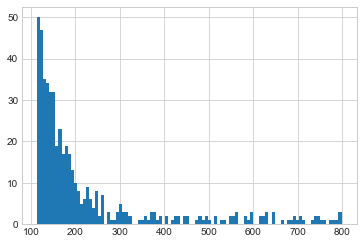

In [63]:
plt.hist(weights, bins=100);

In [64]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items() if w > 200])

In [65]:
nds = set(x[0] for x in edges).union(set(x[1] for x in edges))

In [73]:
'persons' in cmp.intersection(nds)

False

75


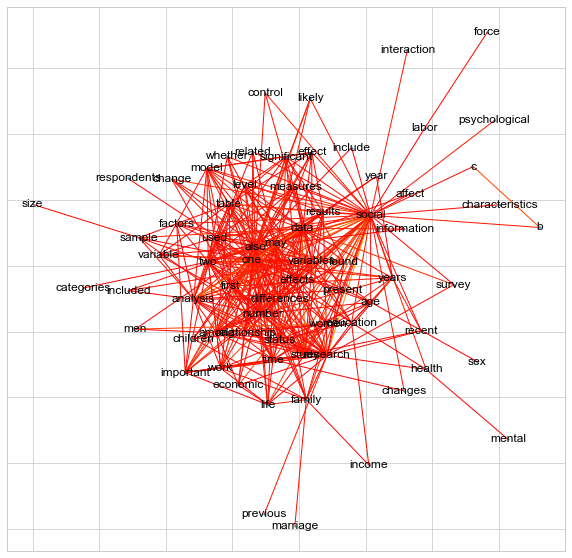

1
1


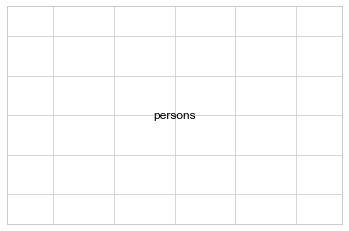

2


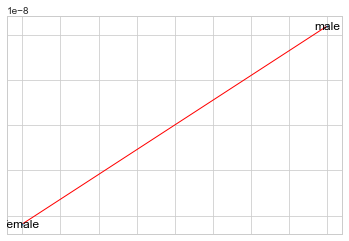

1
1


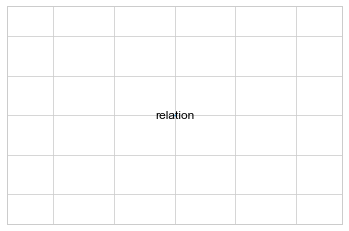

1


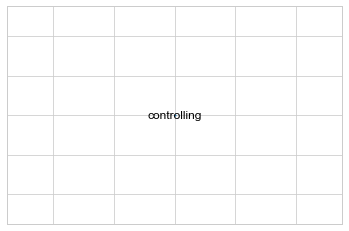

1


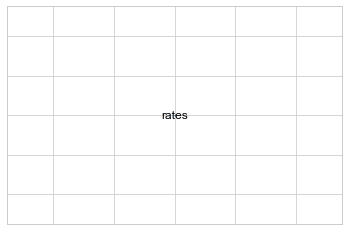

1
1


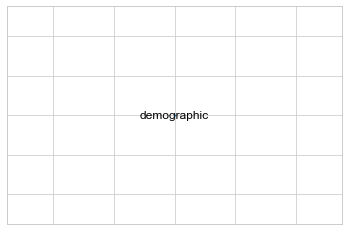

1


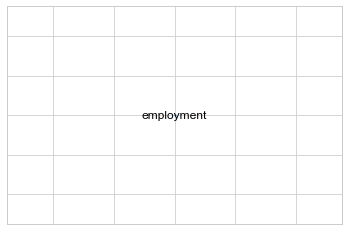

1


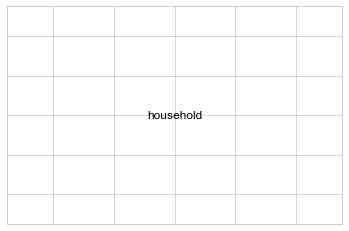

1


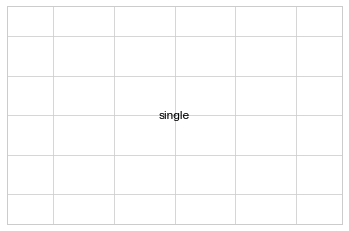

1
1
1


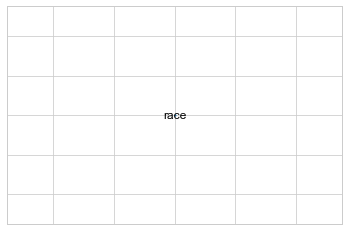

1


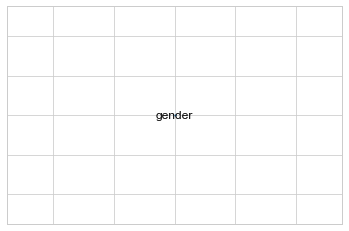

1


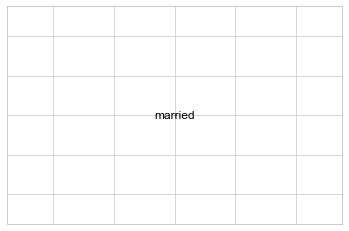

In [78]:
plt.figure(figsize=(10,10))
for cmp in nx.connected_components(G):
    print(len(cmp))
    if not len(cmp.intersection(nds)):
        continue
        
    cmp = nx.subgraph(G, cmp.intersection(nds))
    #cmp = nx.subgraph(cmp,nds)
    
    edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(cmp,'weight').items()])

    pos = nx.kamada_kawai_layout(cmp)
        
    nx.draw_networkx_edges(cmp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=weights)
    nx.draw_networkx_nodes(cmp,pos,node_size=1)
    nx.draw_networkx_labels(cmp,pos)
    plt.show()

# entropy of coword network etc

In [80]:
len(db.items('t'))

9992

In [3]:
mm = db(t1=None, t2=None).docs

loading variable sociology-jstor-all/doc ___ t1.t2 from disk


In [9]:
r

(14456,
 t2       ability
 t1       ability
 count        282
 Name: 14456, dtype: object)

In [16]:
terms = sorted(db.items('t'))
t2i = {t:i for i,t in enumerate(terms)}

shp = len(terms)
mat = np.zeros((shp,shp))


for i,r in mm.iterrows():
    mat[ t2i[r.t1], t2i[r.t2] ] = r['count']

In [17]:
mat.shape

(1000, 1000)

In [18]:
np.sum(mat)

34453536.0

In [24]:
mat[1,3]

37.0

In [79]:
vocab = sorted(db.items('t'))
ents = []
for t in vocab:
    ns = np.array([ db(t1=t, t2=x).docs for x in vocab ])
    ns = ns[ns>0]
    ns = ns / np.sum(ns)
    
    ent = -np.sum(np.log(ns) * ns)
    ents.append(ent)

KeyboardInterrupt: 

In [ ]:
len(ents)

In [ ]:
ents[:10]

In [35]:
ns = np.array([ db(t1='behavior', t2=x).docs for x in vocab ])

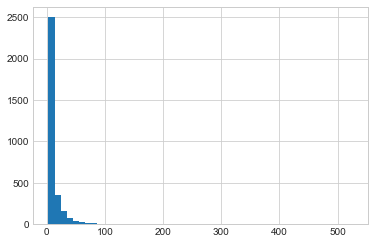

In [42]:
plt.hist(ns[ns>2], bins=50);

In [43]:
ns = np.array([ db(t1='american-behavioral', t2=x).docs for x in vocab ])

In [47]:
db(t1='american-behavioral', t2=None).cits.sort_values

,t2,count
6,age,1
0,american,26
2,american-behavioral,26
4,behavioral,26
3,behavioral-scientist,26
14,communities,1
10,december,1
11,future,1
7,issue,1
16,knowledge,1


In [ ]:
plt.hist([x for x in ents if not np.isnan(x)], 100);

In [ ]:
# highest entropy
[(vocab[i], ents[i]) 
 for x,i in sorted([y,i] for i,y in enumerate(ents))[-20:]]

In [ ]:
# lowest entropy
[(vocab[i], ents[i]) 
 for x,i in sorted([y,i] for i,y in enumerate(ents))[:10]]

# measure based on independence

$$ P(a \& b) / [P(a)*P(b)] = \frac{ \frac{N(a \& b)}{\sum_x{N(x \& b)}} \frac{N(b)}{N} }{ \frac{N(a)*N(b)}{N^2} } $$

where

$$ N=\sum_x{N(x)} $$

if it's significantly larger than 1, we have an edge a,b

$$ P_{a\to b} $$

$$ P_{a\to X} = \sum_x P_{a\to x} = 5 = \text{Number of words that follow any given word `a`} $$

$$ C_{a\to b} $$ 

$$ P_{a\to b} = P( w_{i+j} = b | w_i = a; j\leq 5 ) $$

$$ w_i = \text{Word i} $$

Assume that 5 words follow every word that is present (not strictly true).
Then,

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

In [26]:
sample(db.items('t'), 5)

['shows', 'taking-account', 'increase', 'research-social', 'process']

In [29]:
a = db(t1='taking-account', t2=None).docs
b = db(t='taking-account').docs

loading variable sociology-jstor-all/doc ___ t from disk


In [37]:
vals = []
for t in sample(db.items('t'), 20):
    a = db(t1=t, t2=None).docs
    b = db(t=t).docs
    
    ac = a['count'].sum()
    vals.append( (ac, b, ac / b) )

In [38]:
vals

[(36019, 2970, 12.127609427609428),
 (41273, 2714, 15.20744288872513),
 (111387, 4140, 26.905072463768114),
 (3466, 586, 5.914675767918089),
 (39285, 2442, 16.087223587223587),
 (40034, 3142, 12.741565881604075),
 (42650, 2992, 14.254679144385026),
 (65742, 3505, 18.756633380884452),
 (4679, 581, 8.053356282271945),
 (7367, 466, 15.80901287553648),
 (34754, 3279, 10.598963098505642),
 (3822, 444, 8.608108108108109),
 (7480, 629, 11.891891891891891),
 (24598, 2386, 10.309304274937134),
 (28436, 2552, 11.142633228840126),
 (45589, 2405, 18.955925155925154),
 (3521, 571, 6.166374781085814),
 (26482, 2671, 9.914638712092849),
 (26570, 2641, 10.060583112457403),
 (7611, 667, 11.410794602698651)]

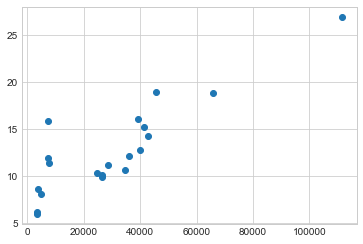

In [42]:
plt.scatter(
    [x[0] for x in vals],
    [x[2] for x in vals],
)

In reality, these ratios seem to vary considerably, between 6 and 16... And this relation seems to depend on the total, but not in a perfect-ratio sort of way... What's going on?

Oh, this is with *documents* not individual instances... Duh let's try it with "citations" instead

In [47]:
vals = []
for t in sample(db.items('t'), 20):
    a = db(t1=t, t2=None).cits
    b = db(t=t).cits
    
    ac = a['count'].sum()
    vals.append( (ac, b, ac / b) )

In [48]:
vals

[(47131, 9427, 4.9995756868569),
 (5711, 1143, 4.996500437445319),
 (51834, 10377, 4.995085284764383),
 (6138, 1229, 4.994304312449145),
 (4203, 844, 4.979857819905213),
 (9470, 1895, 4.997361477572559),
 (403275, 80950, 4.981778875849289),
 (35492, 7099, 4.999577405268347),
 (4802, 961, 4.99687825182102),
 (68992, 13849, 4.981731532962669),
 (173840, 34776, 4.998849781458477),
 (9934, 1988, 4.996981891348089),
 (62108, 12492, 4.971821966058277),
 (28637, 5734, 4.99424485524939),
 (73647, 14732, 4.999117567200652),
 (4893, 991, 4.937436932391524),
 (3095, 619, 5.0),
 (52773, 10557, 4.998863313441318),
 (4234, 848, 4.992924528301887),
 (2585, 520, 4.971153846153846)]

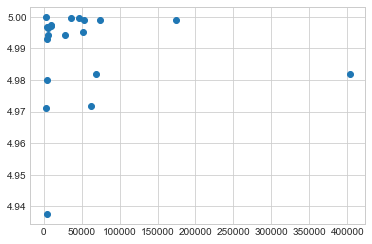

In [49]:
plt.scatter(
    [x[0] for x in vals],
    [x[2] for x in vals],
)

Now it's right around 5. 4.93 at a minimum in this sample of 20, and 5 a strict maximum. This makes more sense...

# solidified a bit

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

$$ P( \text{b shows up after a} ) = 1 - \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] } $$

$$ P( w_{j+N} = b | w_j = a ) = ?? $$

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) \in [0, 5] $$

Now I want to measure how surprising a given connection is compared to the individual propensities.
Something similar to // independence indicates that

$$P(A \& B) = P(A) * P(B|A) = P(A) * P(B)$$

Where the last equality expresses the independence assumption. The extent to which the leftmost and rightmost quantities differ is a good measure for the relevance of a single tie between events.
So, assume $a$ and $b$ are independent events. From above we know that

$$P(a \to b) = \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] }$$

And by independence this is just

$$ \prod_N{ \left[ 1 - P( w_{j+N} = b ) \right] } $$

$$ P( w_{j+N} = b ) = \text{count-t}(b) * 5 $$

So we almost get what we want... Let's try another combo of formulas...

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) $$
$$ = \sum_{N=1}^5 P( w_{j+N} = b ) = \sum_{N=1}^5 \frac{ \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} } = \frac{ 5 * \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} }  $$

By this math the relevant ratio is

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

In [51]:
examples = sample(db.items('t'), 20)

In [59]:
t1 = examples[0]
c = db(t1=t1, t2=None).cits

In [61]:
tot = db(t=None).cits['count'].sum()

In [73]:
rats = []
terms = []

for i,r in c.iterrows():
    ca = db(t=t1).cits
    cb = db(t=r.t2).cits
    
    cab = r['count']
    
    rat = tot * cab / (ca * cb)
    
    terms.append(r.t2)
    rats.append( rat )

rats = np.array(rats)

In [86]:
terms = np.array(terms)

In [74]:
np.argwhere( rats > 5 ).shape

(211, 1)

In [75]:
np.argwhere( rats < 5 ).shape

(398, 1)

(array([ 5., 10., 19., 16., 27., 19., 18., 21., 15., 17.]),
 array([0.15257036, 0.33692137, 0.52127239, 0.70562341, 0.88997442,
        1.07432544, 1.25867646, 1.44302748, 1.62737849, 1.81172951,
        1.99608053]),
 <a list of 10 Patch objects>)

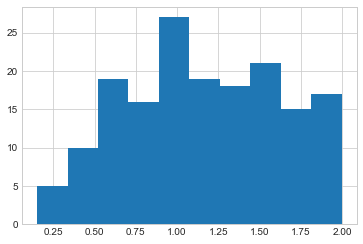

In [84]:
plt.hist( rats[(rats<2)&(rats>-5)] )

In [85]:
np.quantile(rats, 0.9)

11.615839525659679

significant-differences


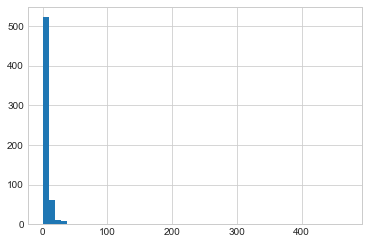

In [68]:
rats = np.array(rats)

print(examples[0])
plt.hist( rats, bins=50 );

In [89]:
print(t1)
terms[ np.argwhere( rats > 15 ) ]

significant-differences


array([['across'],
       ['among'],
       ['attitudes-toward'],
       ['based-upon'],
       ['black-white'],
       ['dependent-variables'],
       ['descriptive-statistics'],
       ['differences'],
       ['differences-among'],
       ['either'],
       ['ethnic-groups'],
       ['found'],
       ['found-among'],
       ['groups'],
       ['high-low'],
       ['however-also'],
       ['human-capital'],
       ['least-two'],
       ['male-female'],
       ['males-females'],
       ['marital-status'],
       ['men-women'],
       ['observed'],
       ['per-se'],
       ['respect'],
       ['see-table'],
       ['significant-differences'],
       ['significantly'],
       ['two'],
       ['two-groups'],
       ['two-measures'],
       ['version-paper'],
       ['women-men'],
       ['young-adults'],
       ['young-people']], dtype='<U25')

# now map it across the whole terms list to make a network

In [90]:
mat.shape

(1000, 1000)

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

or more relevant even...

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ 5 * \text{count-t}(a) * \text{count-t}(b) } = 1 $$

In [98]:
s = np.sum(mat, axis=0)
stot = np.sum(s)

In [95]:
np.sum(sa) == np.sum(sb)

True

In [99]:
# 0 -> 1?
mat[0,1] * stot / ( s[0] * s[1] )

2.155973419851163

In [105]:
# a -> b?
a = 0
cab = mat[a] # count-t.t(a,b)

rat = ( cab * stot / ( sa[a] * s ) )
print( rat[:5] )
print( rat.shape )

[8.9326765  2.15597342 0.         1.25618088 1.66093239]
(1000,)


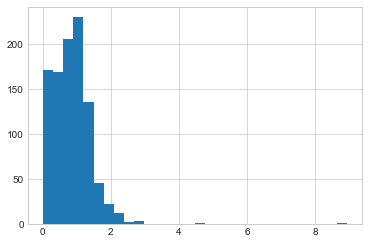

In [110]:
plt.hist( rat, bins=30 );

Checks out...

In [113]:
((mat * stot / s).T / sa).T[ 0, 1 ]

2.155973419851163

And that's it! I transformed the network w/o any computation hardly XD

In [114]:
mat_transform = ((mat * stot / s).T / sa).T

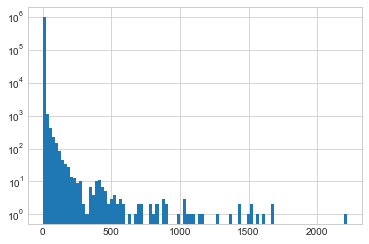

In [118]:
plt.hist(mat_transform.flatten(), bins=100, log=True);

In [119]:
wts = mat_transform.flatten()

In [138]:
to_keep = np.quantile(wts[wts>0], 0.95)
to_keep

2.979687076929689

In [139]:
np.sum(mat_transform > 0)

745670

In [140]:
np.sum(mat_transform > to_keep)

37284

In [141]:
mat_filter = mat_transform * (mat_transform > to_keep)

In [142]:
np.sum(mat_filter > 0) # number of edges

37284

In [143]:
np.sum(mat_filter > 0) / mat_filter.shape[0] # average degree

37.284

In [185]:
G = nx.Graph()

In [186]:
G.add_weighted_edges_from([
    (ts[ti1], ts[ti2], mat_filter[ti1,ti2])
    for ti1 in tis
    for ti2 in tis
    if ti1 < ti2 and mat_filter[ti1,ti2] > 0
])

In [187]:
tis = range(200)
ts = [terms[i] for i in tis]

In [188]:
deg = np.array(list(x[1] for x in G.degree()))

In [189]:
np.where( deg < 3 )

(array([  0,   2,  32,  42,  44,  52,  66,  69,  72,  74,  77,  78,  85,
         88,  89,  99, 100, 110, 125, 133, 135, 136, 137, 138, 139, 140,
        141, 143, 144, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168], dtype=int64),)

In [190]:
G.remove_nodes_from( list(np.where( deg < 3 )[0]) )

In [191]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items() if w > 0])

In [194]:
wlim = np.quantile( np.array(weights), 0.95)

In [204]:
e = list(G.edges)

In [205]:
G.remove_edges_from( [e[i] for i in list(np.where( np.array(weights) < wlim )[0])] )

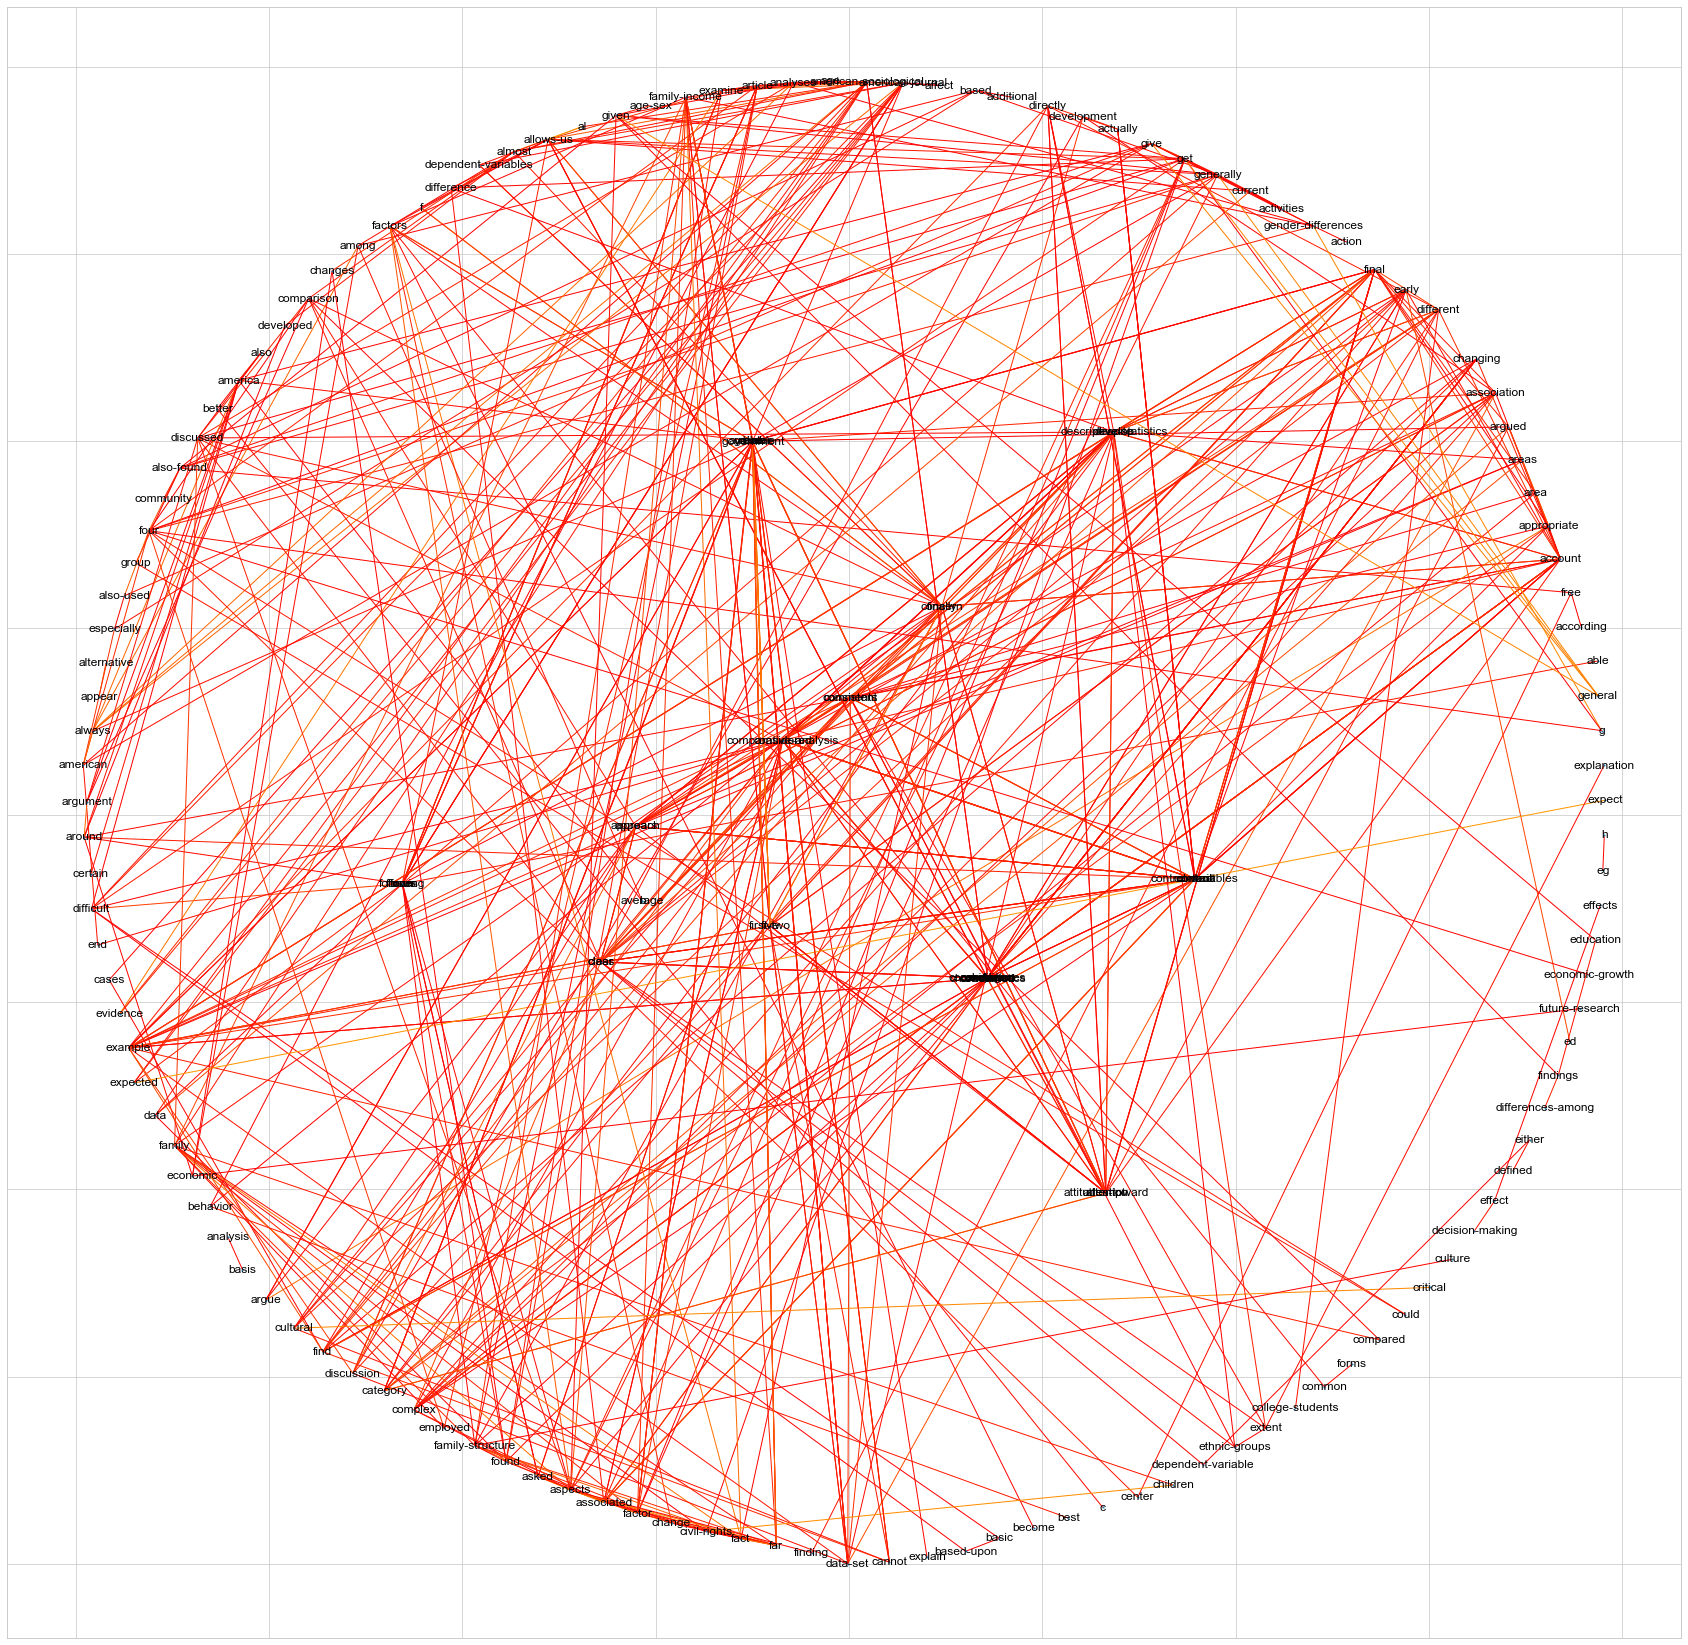

In [207]:
plt.figure(figsize=(30,30))

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_edges(G,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=np.log(weights))
nx.draw_networkx_nodes(G,pos,node_size=1)
nx.draw_networkx_labels(G,pos)
plt.show()

# just try outputting & use Gephi

In [209]:
from csv import writer

In [216]:
terms = sorted(db.items('t'))

In [221]:
mat_to_write = mat_transform

tis = range(mat_to_write.shape[0])
ts = terms

print(len(ts), len(tis))

ns = set()

with open('first_cooc.csv', 'w', encoding='utf8') as outf:
    
    w = writer(outf)
    w.writerow(['Source', 'Target', 'Weight'])
    
    for ti1 in tis:
        for ti2 in tis:
            if ti1 == ti2:
                continue
            if mat_filter[ti1,ti2] == 0:
                continue
                
            w.writerow([ts[ti1], ts[ti2], mat_to_write[ti1,ti2]])
            
            ns.add(ts[ti1])
            ns.add(ts[ti2])

1000 1000


In [223]:
len(ns)

998

Loading this coocurrence network first_cooc.csv into Gephi produced good results.

+ there is a cluster of single-letter words a -> d -> etc... which should be ignored
+ there are many words which show up equally in articles from a given journal (i.e. extremely high entropy across journals) which should be removed
+ there are many words which show up equally in all articles, usually regarding the flow, that can be removed
+ the window should be increased, and should be modified when terms are encountered, which are always followed by the second word of the term
+ it's actually good that a given term points strongly to a word that's contained in it (that's the immediate next word)
+ there are interpretable results already, but it's clear that 1k words just isn't enough. t1.t2 is only 24M with 1k words. It's not storage, it's only memory?
+ I also need to store fy.t1.t2